# Classification ( In progress)

In [320]:
import pandas as pd
import numpy as np
import re
import spacy
from spacy.lang.en import English
from spacy import displacy
nlp = spacy.load('en_core_web_sm', disable=["ner", "textcat", "entity_ruler", "merge_noun_chunks", "merge_entities", "merge_subtokens"])

In [321]:
from IPython.display import Image
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import seaborn as sns
import matplotlib.pylab as plt
from warnings import filterwarnings
filterwarnings('ignore')

In [322]:
from xgboost import XGBClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import KFold
from nltk.corpus import stopwords
import string

In [323]:
from sklearn.feature_extraction.text import CountVectorizer,HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.linear_model import SGDClassifier, LogisticRegression,LogisticRegressionCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import SVC,LinearSVC
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

In [324]:
options = {"compact": True, "bg": "#09a3d5",
           "color": "white", "font": "Source Sans Pro","collapse_phrases":False}

In [325]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('max_colwidth', 260)

In [326]:
dfExoplanetsNASAannot = pd.read_json('../data/dfExoplanetsNASAdetected100rand_v2.json', orient = 'table')
del dfExoplanetsNASAannot['tagRootSent']
del dfExoplanetsNASAannot['tagDetected']
dfExoplanetsNASAannot.head(20)

,sent,label
0,"We detected visual companions within 1'' for 5 stars, between 1'' and 2'' for 7 stars, and between 2'' and 4'' for 15 stars.",discovery
1,"Using these data and photometry from the Spitzer Space Telescope, we have identified members with infrared excess emission from circumstellar disks and have estimated the evolutionary stages of the detected disks, which include 31 new full disks and 16 new...",discovery
2,"Of the over 800 exoplanets detected to date, over half are on non-circular orbits, with eccentricities as high as 0.93.",None
3,"We find that for these false positive scenarios, CO at 2.35 μm, CO_2 at 2.0 and 4.3 μm, and O_4 at 1.27 μm are all stronger features in transmission than O_2/O_3 and could be detected with S/Ns ≳ 3 for an Earth-size planet orbiting a nearby M dwarf star wi...",discovery
4,We present two exoplanets detected at Keck Observatory.,discovery
5,"This disfavours the possibility of GI-caused spiral structure in systems with q&lt;0.25 being detected in relatively short integration times, such as those found in the DSHARP ALMA survey (Andrews et al. 2018; Huang et al. 2018).",None
6,"Planets lying in this zone are then more easily detected with the radial-velocity method [3], the most successful in detecting exoplanets.",None
7,"The 2004 flux density was 0.05 Jy, about an order of magnitude lower than the single 2003 burst and the five bursts detected in 2002.",discovery
8,"This statement is supported by a figure given in the article, which shows a primary signal with a depth of 6 mmag, detected with 4σ confidence and a possible secondary signal with a depth of 2 mmag.",None
9,"Combining these instruments with powerful telescopes, astronomers have detected thousands of exoplanets.",None


In [327]:
def satz_analytic2(satz):
#    merkmal = dict({"satz":satz.text})
    merkmal=dict({})
# search for main verb
    for t in satz:
        if t.dep_ == "ROOT":
            r=t.head.text
            merkmal.update({"act":r})
# subject and object related to verb
    for t in satz:
#        if t.dep_ == "dobj" and merkmal["act"]==t.head.text:
#            merkmal.update({"obj":''.join(w.text_with_ws for w in t.subtree)})
        if t.dep_ == "nsubj" and merkmal["act"]==t.head.text:
            merkmal.update({"subject":t.text.lower()})

    return(merkmal)


In [328]:
dfExoplanetsNASAannot["s"]=dfExoplanetsNASAannot["sent"].apply(lambda y: satz_analytic2(nlp(y)))
dfExoplanetsNASAannot.head(20)

,sent,label,s
0,"We detected visual companions within 1'' for 5 stars, between 1'' and 2'' for 7 stars, and between 2'' and 4'' for 15 stars.",discovery,"{'act': 'detected', 'subject': 'we'}"
1,"Using these data and photometry from the Spitzer Space Telescope, we have identified members with infrared excess emission from circumstellar disks and have estimated the evolutionary stages of the detected disks, which include 31 new full disks and 16 new...",discovery,"{'act': 'identified', 'subject': 'we'}"
2,"Of the over 800 exoplanets detected to date, over half are on non-circular orbits, with eccentricities as high as 0.93.",None,"{'act': 'are', 'subject': 'half'}"
3,"We find that for these false positive scenarios, CO at 2.35 μm, CO_2 at 2.0 and 4.3 μm, and O_4 at 1.27 μm are all stronger features in transmission than O_2/O_3 and could be detected with S/Ns ≳ 3 for an Earth-size planet orbiting a nearby M dwarf star wi...",discovery,"{'act': 'find', 'subject': 'we'}"
4,We present two exoplanets detected at Keck Observatory.,discovery,"{'act': 'present', 'subject': 'we'}"
5,"This disfavours the possibility of GI-caused spiral structure in systems with q&lt;0.25 being detected in relatively short integration times, such as those found in the DSHARP ALMA survey (Andrews et al. 2018; Huang et al. 2018).",None,{'act': 'al'}
6,"Planets lying in this zone are then more easily detected with the radial-velocity method [3], the most successful in detecting exoplanets.",None,{'act': 'detected'}
7,"The 2004 flux density was 0.05 Jy, about an order of magnitude lower than the single 2003 burst and the five bursts detected in 2002.",discovery,"{'act': 'was', 'subject': 'density'}"
8,"This statement is supported by a figure given in the article, which shows a primary signal with a depth of 6 mmag, detected with 4σ confidence and a possible secondary signal with a depth of 2 mmag.",None,{'act': 'supported'}
9,"Combining these instruments with powerful telescopes, astronomers have detected thousands of exoplanets.",None,"{'act': 'detected', 'subject': 'astronomers'}"


In [329]:
_all_xs=list(dfExoplanetsNASAannot["sent"])


In [330]:
_all_ys=np.array(list(dfExoplanetsNASAannot["label"]))

In [331]:
def transp(x):
    if x=="discovery":
        y=1
    else:
        y=0
    return(y)
dfExoplanetsNASAannot["label"]=dfExoplanetsNASAannot["label"].apply(lambda x: transp(x))

In [332]:
dfExoplanetsNASAannot.head(10)

,sent,label,s
0,"We detected visual companions within 1'' for 5 stars, between 1'' and 2'' for 7 stars, and between 2'' and 4'' for 15 stars.",1,"{'act': 'detected', 'subject': 'we'}"
1,"Using these data and photometry from the Spitzer Space Telescope, we have identified members with infrared excess emission from circumstellar disks and have estimated the evolutionary stages of the detected disks, which include 31 new full disks and 16 new...",1,"{'act': 'identified', 'subject': 'we'}"
2,"Of the over 800 exoplanets detected to date, over half are on non-circular orbits, with eccentricities as high as 0.93.",0,"{'act': 'are', 'subject': 'half'}"
3,"We find that for these false positive scenarios, CO at 2.35 μm, CO_2 at 2.0 and 4.3 μm, and O_4 at 1.27 μm are all stronger features in transmission than O_2/O_3 and could be detected with S/Ns ≳ 3 for an Earth-size planet orbiting a nearby M dwarf star wi...",1,"{'act': 'find', 'subject': 'we'}"
4,We present two exoplanets detected at Keck Observatory.,1,"{'act': 'present', 'subject': 'we'}"
5,"This disfavours the possibility of GI-caused spiral structure in systems with q&lt;0.25 being detected in relatively short integration times, such as those found in the DSHARP ALMA survey (Andrews et al. 2018; Huang et al. 2018).",0,{'act': 'al'}
6,"Planets lying in this zone are then more easily detected with the radial-velocity method [3], the most successful in detecting exoplanets.",0,{'act': 'detected'}
7,"The 2004 flux density was 0.05 Jy, about an order of magnitude lower than the single 2003 burst and the five bursts detected in 2002.",1,"{'act': 'was', 'subject': 'density'}"
8,"This statement is supported by a figure given in the article, which shows a primary signal with a depth of 6 mmag, detected with 4σ confidence and a possible secondary signal with a depth of 2 mmag.",0,{'act': 'supported'}
9,"Combining these instruments with powerful telescopes, astronomers have detected thousands of exoplanets.",0,"{'act': 'detected', 'subject': 'astronomers'}"


In [333]:
_all_xs[1]

'Using these data and photometry from the Spitzer Space Telescope, we have identified members with infrared excess emission from circumstellar disks and have estimated the evolutionary stages of the detected disks, which include 31 new full disks and 16 new candidate transitional, evolved, evolved transitional, and debris disks.'

In [334]:
X=list(dfExoplanetsNASAannot["sent"])
y=np.array(list(dfExoplanetsNASAannot["label"]))



In [335]:
from collections import Counter
Category=Counter(y)
Counter=dict(Category)

In [336]:
Counter

{1: 40, 0: 60}

Text(0.5, 1.0, 'Distribution of samples over different classes')

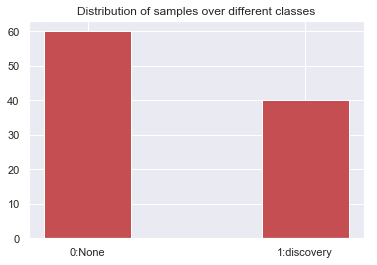

In [337]:
plt.bar(list(Counter.keys()),Counter.values(),color="r",width=.4,tick_label=["1:discovery","0:None"])
plt.title("Distribution of samples over different classes")


In [338]:
X,y = shuffle(X, y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
X,y, test_size=0.25, random_state=42)    


In [339]:
len(y)

100

# Baseline models

while training and buliding a model, we should keep in mind that there is never the best one. It is realtively experimental process. We start to try different trials. we trired different evaluation metrics

We have tried the following models:
- Multinomial Naïve Bayes
- XGBoosts classifier
- Random Forest
- Support Vector Machine
-  SGD Classifier


In [340]:
def train_predict(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_test=clf.predict(X_test)
    return y_test

In [341]:
def cross_validation_accuracy(clf,X,y):
    scores = cross_val_score(clf, X, y, cv=3)
    print(scores)
    print('Accuracy of : {:.3f} ± {:.3f}'.format(np.mean(scores), 2 * np.std(scores)))

In [342]:
def Color_Confusion_Matrix(y, y_test, y_pred):
    cm=confusion_matrix(y_test, y_pred)
    l=len(set(y))
    df_cm = pd.DataFrame(cm, range(l), range(l))
    sns.set(font_scale=1)
    sns.heatmap(df_cm,cmap="Blues", annot=True,annot_kws={"size": 16})
    plt.ylabel('True label');
    plt.xlabel('Predicted label');
    plt.title("Confusion Matrix", size = 16)
    plt.savefig('CM_Test_01.png')

In [343]:
from sklearn.metrics import roc_curve  
from sklearn.metrics import roc_auc_score 
def plot_roc_curve(fpr, tpr,auc):  
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve with AUC {:.3f}'.format(AUC))
    plt.legend()
    plt.show()

# Baseline Models

In [344]:
## 01-Naive Bayes
trial_01=Pipeline([ ('vectorizer', TfidfVectorizer()), ('classifier', MultinomialNB())])
################################################################################

## 02-XGBClassifier
trial_02 = Pipeline([('vect', CountVectorizer(stop_words='english')),
                     ('clf', XGBClassifier())])
################################################################################
## 03-Random Forest Classifier
trial_03= Pipeline([('vect', CountVectorizer(stop_words='english')),
                     ('clf', RandomForestClassifier())])

################################################################################
## 04-SVC Classifier
vec = TfidfVectorizer(min_df=3,ngram_range=(1, 2))
svd = TruncatedSVD()
pipe = make_pipeline(vec, svd)
clf = SVC()
trial_04 = make_pipeline(pipe, clf)

#################################################################################
# 05- SGD Classifier
vec=TfidfVectorizer()
clf= SGDClassifier(max_iter=70,tol=.001)
trial_05=Pipeline([("vect",vec),("clf",clf)]).fit(X_train,y_train)

#################################################################################



# Training and Prediction by XGBCalssifier

In [345]:
y_pred=train_predict(trial_02,X_train,y_train,X_test,y_test)

# Evaluation

First we used classification report and confusion matrix for a test set  . Then we show the result of classifcation report and confusion matrix over ten folds to have unibased evaluation metrics. here we have chosen two models among 5 models that we tried.

 ## a) train-test-split

              precision    recall  f1-score   support

           0       0.60      0.86      0.71        14
           1       0.60      0.27      0.37        11

   micro avg       0.60      0.60      0.60        25
   macro avg       0.60      0.56      0.54        25
weighted avg       0.60      0.60      0.56        25



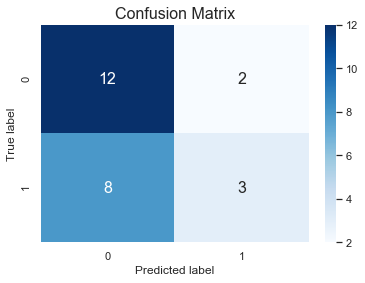

In [346]:
cr=classification_report(y_test,y_pred)
print(cr)
Color_Confusion_Matrix(y=y,y_test=y_test,y_pred=y_pred)

## b) 10 fold cross valdiation

In [347]:
cross_validation_accuracy(trial_02,X,y)

[0.52941176 0.48484848 0.54545455]
Accuracy of : 0.520 ± 0.051


              precision    recall  f1-score   support

           0       0.61      0.58      0.60        60
           1       0.42      0.45      0.43        40

   micro avg       0.53      0.53      0.53       100
   macro avg       0.52      0.52      0.52       100
weighted avg       0.54      0.53      0.53       100



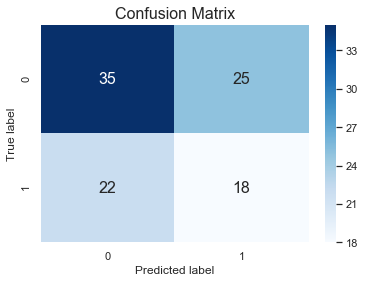

In [348]:
y_pred = cross_val_predict(trial_02, X, y, cv=5)
cr=classification_report(y,y_pred)
print(cr)
cm = confusion_matrix(y_pred,y)
Color_Confusion_Matrix(y=y,y_test=y,y_pred=y_pred)

### ROC curve and AUC value

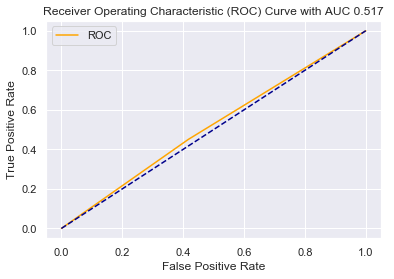

In [349]:
AUC = roc_auc_score(y,y_pred)  
fpr, tpr, thresholds = roc_curve(y,y_pred) 
plot_roc_curve(fpr,tpr,AUC)

# Training and Prediction by SGDClassifier

In [350]:
y_pred=train_predict(trial_05,X_train,y_train,X_test,y_test)

# Evaluation

## a) train-test-split

              precision    recall  f1-score   support

           0       0.56      0.71      0.63        14
           1       0.43      0.27      0.33        11

   micro avg       0.52      0.52      0.52        25
   macro avg       0.49      0.49      0.48        25
weighted avg       0.50      0.52      0.50        25



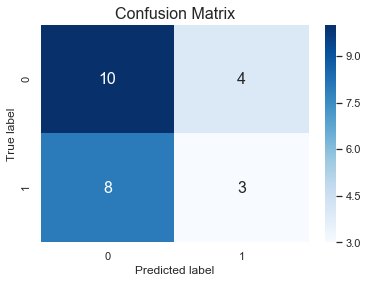

In [351]:
cr=classification_report(y_test,y_pred)
print(cr)
Color_Confusion_Matrix(y=y,y_test=y_test,y_pred=y_pred)

## b) 10 fold cross valdiation

              precision    recall  f1-score   support

           0       0.60      0.95      0.74        60
           1       0.40      0.05      0.09        40

   micro avg       0.59      0.59      0.59       100
   macro avg       0.50      0.50      0.41       100
weighted avg       0.52      0.59      0.48       100



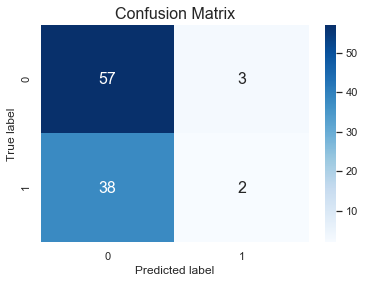

In [352]:
y_pred = cross_val_predict(trial_03, X, y, cv=5)
cr=classification_report(y,y_pred)
print(cr)
cm = confusion_matrix(y_pred,y)
Color_Confusion_Matrix(y=y,y_test=y,y_pred=y_pred)

### ROC curve and AUC value

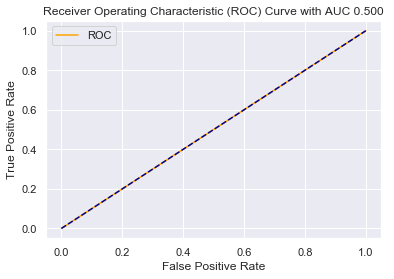

In [353]:
AUC = roc_auc_score(y,y_pred)  
fpr, tpr, thresholds = roc_curve(y,y_pred) 
plot_roc_curve(fpr,tpr,AUC)

# Parameter Tuning on XGB Classifier

In [354]:
param_grid= {
    'vect__max_df': (0.25, 0.5, 0.75),
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
   'clf__max_iter' : [400],
   'clf__tol' : np.logspace(-4,0,5)
}
trial_02_01 = GridSearchCV(trial_02, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0, error_score=0)

In [355]:
y_pred=train_predict(trial_02_01,X_train,y_train,X_test,y_test)

## Evaluation after parameter tuning

              precision    recall  f1-score   support

           0       0.60      0.86      0.71        14
           1       0.60      0.27      0.37        11

   micro avg       0.60      0.60      0.60        25
   macro avg       0.60      0.56      0.54        25
weighted avg       0.60      0.60      0.56        25



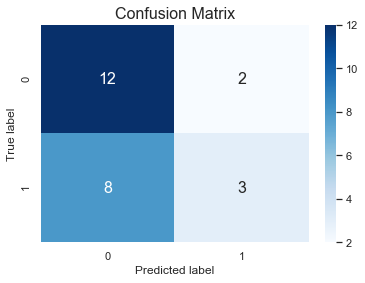

In [356]:
cr=classification_report(y_test,y_pred)
print(cr)
Color_Confusion_Matrix(y=y,y_test=y_test,y_pred=y_pred)

cross_validation_accuracy(trial_02_01,X,y)

              precision    recall  f1-score   support

           0       0.61      0.58      0.60        60
           1       0.42      0.45      0.43        40

   micro avg       0.53      0.53      0.53       100
   macro avg       0.52      0.52      0.52       100
weighted avg       0.54      0.53      0.53       100



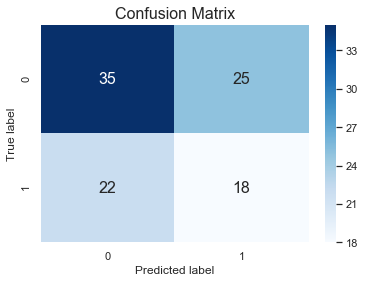

In [357]:
y_pred = cross_val_predict(trial_02_01, X, y, cv=5)
cr=classification_report(y,y_pred)
print(cr)
cm = confusion_matrix(y_pred,y)
Color_Confusion_Matrix(y=y,y_test=y,y_pred=y_pred)

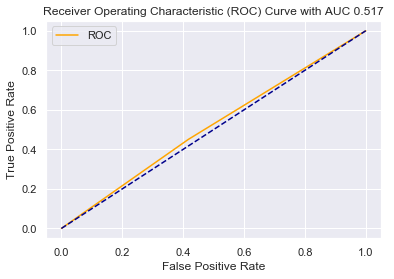

In [358]:
AUC = roc_auc_score(y,y_pred)  
fpr, tpr, thresholds = roc_curve(y,y_pred) 
plot_roc_curve(fpr,tpr,AUC)

As you see the results are improved by parameter tuning

# Explaining prediction by XGB classifier using eli5

In [359]:
from eli5 import show_weights
show_weights(trial_05, top=60)

Weight?,Feature
+6.082,we
+4.063,radio
+3.985,line
+3.965,on
+3.790,which
+3.559,layer
+3.379,features
+3.285,reliably
+3.235,ocean
+3.082,rotation


In [360]:
import eli5
eli5.show_prediction(clf, X_train[22],vec=vec)

In [361]:
eli5.show_prediction(clf, X_train[28],vec=vec)

In [362]:
eli5.show_prediction(clf, X_train[55],vec=vec)

In [363]:
eli5.show_prediction(clf, X_train[25],vec=vec)

# Subject Object features

ELi5's explanation can give us a motivation to work on subject (also object) features 

In [364]:
X_f=list(dfExoplanetsNASAannot["s"])



The features here are subjects and objects as following

In [365]:
X_f[0:5]

[{'act': 'detected', 'subject': 'we'},
 {'act': 'identified', 'subject': 'we'},
 {'act': 'are', 'subject': 'half'},
 {'act': 'find', 'subject': 'we'},
 {'act': 'present', 'subject': 'we'}]

In [366]:
X,y = shuffle(X_f, y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
X,y, test_size=0.25, random_state=42)    

# XGB classifier on subject-object features

In [367]:
clf = XGBClassifier()
vec = DictVectorizer()
pipeline = make_pipeline(vec, clf)



# Evalutaion 

In [368]:
cross_validation_accuracy(pipeline,X,y)

[0.47058824 0.60606061 0.60606061]
Accuracy of : 0.561 ± 0.128


In [369]:
y_pred=train_predict(pipeline,X_train,y_train,X_test,y_test)

              precision    recall  f1-score   support

           0       0.71      0.62      0.67        16
           1       0.45      0.56      0.50         9

   micro avg       0.60      0.60      0.60        25
   macro avg       0.58      0.59      0.58        25
weighted avg       0.62      0.60      0.61        25



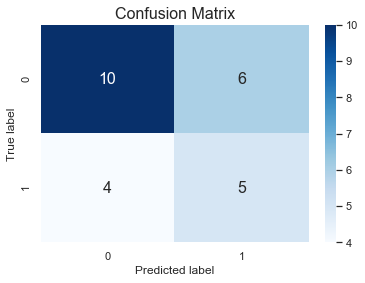

In [370]:
cr=classification_report(y_test,y_pred)
print(cr)
Color_Confusion_Matrix(y=y,y_test=y_test,y_pred=y_pred)

              precision    recall  f1-score   support

           0       0.59      0.83      0.69        60
           1       0.33      0.12      0.18        40

   micro avg       0.55      0.55      0.55       100
   macro avg       0.46      0.48      0.44       100
weighted avg       0.49      0.55      0.49       100



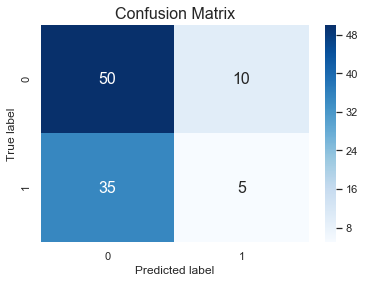

In [371]:
y_pred = cross_val_predict(pipeline, X, y, cv=5)
cr=classification_report(y,y_pred)
print(cr)
cm = confusion_matrix(y_pred,y)
Color_Confusion_Matrix(y=y,y_test=y,y_pred=y_pred)

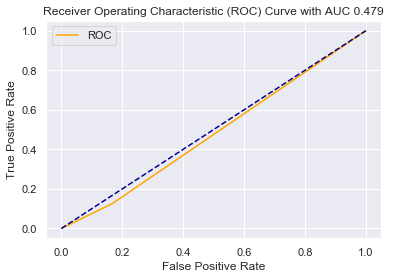

In [372]:
AUC = roc_auc_score(y,y_pred)  
fpr, tpr, thresholds = roc_curve(y,y_pred) 
plot_roc_curve(fpr,tpr,AUC)